# Saliency Maps
In this notebook we create out saliency maps. Saliency maps visualize the impact of each individual pixel on the final classification score. To quantify the "impact" of a pixel, we compute the gradient of the logits with respect to the input pixels. The magnitude of the gradient is then proportional to the "impact" of the pixel on the final score (the gradient scales perturbations in pixel values to affect the final score). We only create saliency maps for the RGB stream as the Flow Stream is already visualy simliar to a saliency map. 

Compute steps:
1. Compute the gradient of the logit corresponding to the correct action class with respect to the input pixels
2. Take the absolute value of the gradient
3. Take the maximum value over all input channels

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

In [1]:
"""
Some setup. 
Installations are the same for the i3d model, which can be found here: https://github.com/deepmind/kinetics-i3d
Make sure i3d.py is in the same directory as this notebook.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
# simply selects which gpu to use
# these lines may very depending on hardware
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) # check gpu is available 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12095823315774573370
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7945581364
locality {
  bus_id: 1
}
incarnation: 8159571723189942701
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [2]:
"""
Build the RBG Graph. Taken from evaluate_sample.py in https://github.com/deepmind/kinetics-i3d
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 79
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'

#FLAGS = tf.flags.FLAGS

#tf.flags.DEFINE_string('eval_type', 'joint', 'rgb, flow, or joint')
#tf.flags.DEFINE_boolean('imagenet_pretrained', True, '')
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.INFO)
#eval_type = FLAGS.eval_type
#imagenet_pretrained = FLAGS.imagenet_pretrained
kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]
rgb_input = tf.placeholder(tf.float32, shape=(1, _SAMPLE_VIDEO_FRAMES, _IMAGE_SIZE, _IMAGE_SIZE, 3))
with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(_NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(rgb_input, is_training=False, dropout_keep_prob=1.0)
rgb_variable_map = {}
for variable in tf.global_variables():
    if variable.name.split('/')[0] == 'RGB':
        rgb_variable_map[variable.name.replace(':0', '')] = variable
rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)
model_logits = rgb_logits
model_predictions = tf.nn.softmax(model_logits)

In [8]:
"""
Run sample prediction with RBG only to validate graph
"""
eval_type = 'rgb'
imagenet_pretrained = True

with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)
        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
Norm of logits: 87.108871

Top classes and probabilities
0.99999666 25.856651 playing cricket
1.3353437e-06 12.330333 playing kickball
4.553111e-07 11.25437 catching or throwing baseball
3.1434072e-07 10.883866 shooting goal (soccer)
1.9243265e-07 10.393135 catching or throwing softball
1.3096499e-07 10.008319 throwing discus
1.0681766e-07 9.804511 javelin throw
9.446424e-08 9.681611 golf putting
7.8428705e-08 9.495579 jogging
7.8017365e-08 9.49032 hitting baseball
6.608467e-08 9.324326 triple jump
3.487841e-08 8.685257 hurling (sport)
2.9965566e-08 8.533438 skateboarding
2.108369e-08 8.181889 hurdling
2.007925e-08 8.133077 playing tennis
1.8453855e-08 8.048662 breakdancing
1.7050759e-08 7.9695835 hammer throw
1.7004478e-08 7.9668655 shot put
1.46112935e-08 7.8151836 long jum

In [4]:
"""
Compute saliency map here
"""
print(model_logits)
print(rgb_input)
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        dX = tf.gradients(model_logits[0, sorted_indices[0]], rgb_input)
        absolute = tf.abs(dX)
        maxes = tf.reduce_max(absolute, axis=5)
        squeezed = tf.squeeze(maxes)
        # change rgb_input to compute new saliency map
        saliency = sess.run(squeezed, feed_dict={rgb_input:rgb_sample}) # this runs on sample cricket gif from i3d README


Tensor("RGB/inception_i3d/Mean:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, 79, 224, 224, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
[<tf.Tensor 'gradients/RGB/inception_i3d/Conv3d_1a_7x7/conv_3d/convolution_grad/Conv3DBackpropInputV2:0' shape=(1, 79, 224, 224, 3) dtype=float32>]


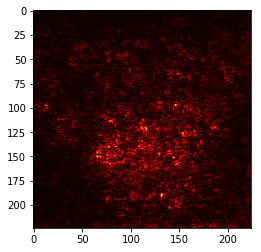

In [7]:
"""
Create/Save saliency map in desired directory. Save indvidual frames to 
This currently computes the provided sample gif
"""

directory = "./saliency/"

if not os.path.exists(directory):
        os.makedirs(directory)
name = directory + "cricket_saliency{}.png"
filenames = []
for i in range(79):
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    # plt.show()
    filename = name.format(i)
    filenames.append(filename)
    plt.savefig(name.format(i))

import imageio
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./saliency/cricket_saliency.gif', images)